In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input
import numpy as np
import os
import cv2

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Set the layers in the base_model to be non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Modify the input layer to accept single-channel images
input_layer = Input(shape=(128, 128, 1))

# Repeat the single channel to create 3 channels
x = Conv2D(3, (3, 3), padding='same')(input_layer)

# Pass this input through the VGG16 model
output = base_model(x)

# Define the modified model
model = Model(inputs=input_layer, outputs=output)
model.summary()


58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
Total params: 14714718 (56.13 MB)
Trainable params: 30 (120.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Directory where augmented images are saved
augmented_image_directory = '/content/drive/MyDrive/EVI_Images/'

# List augmented images
augmented_images = [f for f in os.listdir(augmented_image_directory) if f.endswith('.tif')]

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, (128, 128))
    # Expand dimensions to add a channel dimension (from (128, 128) to (128, 128, 1))
    image_expanded = np.expand_dims(image_resized, axis=-1)
    # Normalize the image
    image_normalized = image_expanded.astype('float32') / 255.0
    return image_normalized

# Load and preprocess all augmented images
x_augmented = np.array([load_and_preprocess_image(os.path.join(augmented_image_directory, img)) for img in augmented_images])


print("Shape of augmented images:", x_augmented.shape)


Shape of augmented images: (5949, 128, 128, 1)


In [ ]:
# Extract features from the augmented images using the modified VGG16
feature_extractor = model.predict(x_augmented)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features

# Check the shape of the extracted features
print("Shape of extracted features:", features.shape)


186/186 [==============================] - 15s 53ms/step
Shape of extracted features: (5949, 8192)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
df = pd.read_excel("/content/iowa2_transposed.xlsx")
df.head()

,Year,yield,state,rainfall,temp
0,2014,172.1,bv,838.48,7.67
1,2015,202.7,bv,912.30,9.35
2,2016,201.1,bv,996.68,9.87
3,2017,187.9,bv,859.57,9.90
4,2018,193.1,bv,1239.26,8.18


In [ ]:
df.shape

(120, 5)

In [ ]:
# Assuming 'features' is already defined and contains the extracted features
num_entries = df.shape[0]

# Truncate the features to match the number of entries in the dataset
truncated_features = features[:num_entries, :]

print("Shape of truncated features:", truncated_features.shape)



Shape of truncated features: (120, 8192)


In [ ]:
# Ensure the dataset has the same number of entries as the truncated features
assert df.shape[0] == truncated_features.shape[0], "Mismatch in number of entries between dataset and truncated features"

# Combine the features with the dataset
data_features = np.hstack((df.values, truncated_features))

# Convert back to DataFrame for easier handling
columns = list(df.columns) + [f'feature_{i}' for i in range(truncated_features.shape[1])]
data_features_df = pd.DataFrame(data_features, columns=columns)

# Display the combined data
data_features_df.head()

,Year,yield,state,rainfall,temp,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_8182,feature_8183,feature_8184,feature_8185,feature_8186,feature_8187,feature_8188,feature_8189,feature_8190,feature_8191
0,2014,172.1,bv,838.48,7.67,0.135639,0.0,0.0,0.0,0.0,...,2.166719,0.355259,0.0,0.191568,1.376492,0.312538,0.61519,0.616304,0.37261,0.0
1,2015,202.7,bv,912.3,9.35,0.076614,0.0,0.0,0.0,0.0,...,1.72003,0.323965,0.394367,0.180452,0.207154,0.469382,0.0,0.0,0.669416,0.0
2,2016,201.1,bv,996.68,9.87,0.025454,0.0,0.0,0.0,0.0,...,2.261751,0.377729,0.0,0.123843,1.192444,0.483797,0.469133,0.503474,0.419589,0.0
3,2017,187.9,bv,859.57,9.9,0.623257,0.0,0.0,0.0,0.0,...,2.640444,0.0,0.0,0.0,0.0,0.194732,0.489277,0.0,0.689023,0.0
4,2018,193.1,bv,1239.26,8.18,1.057644,0.0,0.0,0.0,0.0,...,2.372202,0.114153,0.0,0.0,0.0,0.0,0.843958,0.0,0.399157,0.0


In [ ]:
data_features_df = data_features_df.drop(columns=['state'])
data_features_df.head()

,Year,yield,rainfall,temp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_8182,feature_8183,feature_8184,feature_8185,feature_8186,feature_8187,feature_8188,feature_8189,feature_8190,feature_8191
0,2014,172.1,838.48,7.67,0.135639,0.0,0.0,0.0,0.0,0.0,...,2.166719,0.355259,0.0,0.191568,1.376492,0.312538,0.61519,0.616304,0.37261,0.0
1,2015,202.7,912.3,9.35,0.076614,0.0,0.0,0.0,0.0,0.0,...,1.72003,0.323965,0.394367,0.180452,0.207154,0.469382,0.0,0.0,0.669416,0.0
2,2016,201.1,996.68,9.87,0.025454,0.0,0.0,0.0,0.0,0.0,...,2.261751,0.377729,0.0,0.123843,1.192444,0.483797,0.469133,0.503474,0.419589,0.0
3,2017,187.9,859.57,9.9,0.623257,0.0,0.0,0.0,0.0,0.0,...,2.640444,0.0,0.0,0.0,0.0,0.194732,0.489277,0.0,0.689023,0.0
4,2018,193.1,1239.26,8.18,1.057644,0.0,0.0,0.0,0.0,0.0,...,2.372202,0.114153,0.0,0.0,0.0,0.0,0.843958,0.0,0.399157,0.0


In [ ]:
data_features_df.shape

(120, 8196)

In [ ]:
#Separate dates for future plotting
train_dates = pd.to_datetime(data_features_df['Year'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
cols = list(data_features_df)[1:8197]
#Date and volume columns are not used in training.
print(cols)



['yield', 'rainfall', 'temp', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 

In [ ]:
df_for_training = data_features_df[cols].astype(float)

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)



In [ ]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.


for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (115, 5, 8195).
trainY shape == (115, 1).


In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             2114560   
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2127009 (8.11 MB)
Trainable params: 2127009 (8.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
7/7 [==============================] - 8s 86ms/step - loss: 1.4383 - val_loss: 4.2789
Epoch 2/100
7/7 [==============================] - 0s 26ms/step - loss: 3.2107 - val_loss: 3.0966
Epoch 3/100
7/7 [==============================] - 0s 24ms/step - loss: 1.3263 - val_loss: 3.4386
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 0.7490 - val_loss: 3.2273
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 0.3482 - val_loss: 3.2186
Epoch 6/100
7/7 [==============================] - 0s 26ms/step - loss: 0.4797 - val_loss: 3.3051
Epoch 7/100
7/7 [==============================] - 0s 23ms/step - loss: 0.1941 - val_loss: 3.3098
Epoch 8/100
7/7 [==============================] - 0s 28ms/step - loss: 0.1661 - val_loss: 3.2510
Epoch 9/100
7/7 [==============================] - 0s 42ms/step - loss: 0.1419 - val_loss: 3.3111
Epoch 10/100
7/7 [==============================] - 0s 45ms/step - loss: 0.4628 - val_loss: 3.2515
Epoch 11/100
7/7 [=

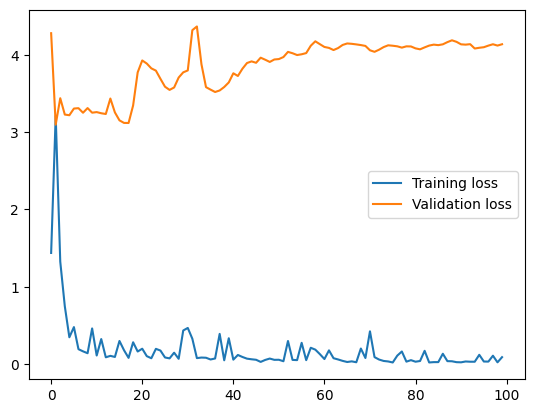

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
